<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/verlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Общая часть

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

G = 6.67430e-11

bodies = {
    'Sun': {
        'mass': 1.9885e30,
        'pos': [0.0, 0.0],
        'vel': [0.0, 0.0]
    },
    'Mercury': {
        'mass': 3.3011e23,
        'pos': [5.791e10, 0.0],
        'vel': [0.0, 47400.0]
    },
    'Venus': {
        'mass': 4.8675e24,
        'pos': [1.082e11, 0.0],
        'vel': [0.0, 35020.0]
    },
    'Earth': {
        'mass': 5.972e24,
        'pos': [1.496e11, 0.0],
        'vel': [0.0, 29780.0]
    },
    'Mars': {
        'mass': 6.4171e23,
        'pos': [2.279e11, 0.0],
        'vel': [0.0, 24070.0]
    },
    'Jupiter': {
        'mass': 1.8982e27,
        'pos': [7.785e11, 0.0],
        'vel': [0.0, 13070.0]
    },
    'Saturn': {
        'mass': 5.6834e26,
        'pos': [1.4335e12, 0.0],
        'vel': [0.0, 9680.0]
    },
    'Uranus': {
        'mass': 8.6810e25,
        'pos': [2.8725e12, 0.0],
        'vel': [0.0, 6800.0]
    },
    'Neptune': {
        'mass': 1.02413e26,
        'pos': [4.4951e12, 0.0],
        'vel': [0.0, 5430.0]
    }
}

def initial_conditions(bodies):
    positions = []
    velocities = []
    masses = []
    for b in bodies.values():
        positions.append(b['pos'])
        velocities.append(b['vel'])
        masses.append(b['mass'])
    return (
        np.array(positions, dtype=np.float64),
        np.array(velocities, dtype=np.float64),
        np.array(masses, dtype=np.float64),
    )

def compute_accelerations(positions, masses):
    n = len(masses)
    accelerations = np.zeros_like(positions)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r_mag = np.linalg.norm(r_vec)
                accelerations[i] += G * masses[j] * r_vec / r_mag**3
    return accelerations

Метод Верле

In [ ]:
def verlet_serial(positions, velocities, masses, dt, steps):
    n = len(masses)
    traj = np.zeros((steps, n, 2))
    traj[0] = positions
    acc = compute_accelerations(positions, masses)

    for t in range(1, steps):
        positions = positions + velocities * dt + 0.5 * acc * dt**2
        acc_new = compute_accelerations(positions, masses)
        velocities = velocities + 0.5 * (acc + acc_new) * dt
        acc = acc_new
        traj[t] = positions
    return traj

Метод Верле с multiprocessing

In [ ]:
from multiprocessing import Pool

# def compute_acc_i(i, positions, masses):
#     acc_i = np.zeros(2)
#     for j in range(len(masses)):
#         if i != j:
#             r_vec = positions[j] - positions[i]
#             r_mag = np.linalg.norm(r_vec)
#             acc_i += G * masses[j] * r_vec / r_mag**3
#     return acc_i
# def compute_accelerations_mp(positions, masses):
#     with Pool() as pool:
#         args = [(i, positions, masses) for i in range(len(masses))]
#         acc = pool.starmap(compute_acc_i, args)
#     return np.array(acc)
# def verlet_mp(positions, velocities, masses, dt, steps):
#     n = len(masses)
#     traj = np.zeros((steps, n, 2))
#     traj[0] = positions
#     acc = compute_accelerations_mp(positions, masses)

#     for t in range(1, steps):
#         positions = positions + velocities * dt + 0.5 * acc * dt**2
#         acc_new = compute_accelerations_mp(positions, masses)
#         velocities = velocities + 0.5 * (acc + acc_new) * dt
#         acc = acc_new
#         traj[t] = positions
#     return traj


def compute_acc_i(i, positions, masses):
    """Вычисляет ускорение для i-го тела."""
    acc_i = np.zeros(2)
    for j in range(len(masses)):
        if i != j:
            r_vec = positions[j] - positions[i]
            r_mag = np.linalg.norm(r_vec)
            acc_i += G * masses[j] * r_vec / r_mag**3
    return acc_i

def compute_accelerations_mp(positions, masses, pool):
    """Вычисляет ускорения для всех тел с использованием пула процессов."""
    args = [(i, positions, masses) for i in range(len(masses))]
    acc = pool.starmap(compute_acc_i, args)
    return np.array(acc)

def verlet_mp(positions, velocities, masses, dt, steps, n_processes=6):
    """Интегрирует траектории методом Верле с использованием multiprocessing."""
    n = len(masses)
    traj = np.zeros((steps, n, 2))
    traj[0] = positions.copy()

    # Создаем пул процессов один раз и переиспользуем
    with Pool(processes=n_processes) as pool:
        acc = compute_accelerations_mp(positions, masses, pool)

        for t in range(1, steps):
            positions += velocities * dt + 0.5 * acc * dt**2
            acc_new = compute_accelerations_mp(positions, masses, pool)
            velocities += 0.5 * (acc + acc_new) * dt
            acc = acc_new
            traj[t] = positions.copy()

    return traj




# import numpy as np
# from multiprocessing import Pool

# G = 6.67430e-11  # гравитационная постоянная

# class NBodySimulator:
#     def __init__(self, num_workers=None):
#         """Инициализация с указанием количества процессов (по умолчанию - количество ядер CPU)"""
#         self.pool = Pool(num_workers)

#     def __del__(self):
#         """Очистка пула процессов при уничтожении объекта"""
#         self.pool.close()
#         self.pool.join()

#     def compute_acc_i(self, args):
#         """Вычисление ускорения для одной частицы"""
#         i, positions, masses = args
#         acc_i = np.zeros(2)
#         for j in range(len(masses)):
#             if i != j:
#                 r_vec = positions[j] - positions[i]
#                 r_mag = np.linalg.norm(r_vec)
#                 acc_i += G * masses[j] * r_vec / r_mag**3
#         return acc_i

#     def compute_accelerations(self, positions, masses):
#         """Параллельное вычисление ускорений для всех частиц"""
#         args = [(i, positions, masses) for i in range(len(masses))]
#         acc = self.pool.map(self.compute_acc_i, args)
#         return np.array(acc)

#     def verlet(self, positions, velocities, masses, dt, steps):
#         """Интегрирование уравнений движения методом Верле"""
#         n = len(masses)
#         traj = np.zeros((steps, n, 2))
#         traj[0] = positions
#         acc = self.compute_accelerations(positions, masses)

#         for t in range(1, steps):
#             positions = positions + velocities * dt + 0.5 * acc * dt**2
#             acc_new = self.compute_accelerations(positions, masses)
#             velocities = velocities + 0.5 * (acc + acc_new) * dt
#             acc = acc_new
#             traj[t] = positions

#         return traj


# import numpy as np
# from multiprocessing import Pool, cpu_count
# import functools

# # Глобальные константы
# G = 6.67430e-11  # гравитационная постоянная

# def compute_acc_i(i, positions, masses):
#     """Вычисление ускорения для i-го тела (оптимизированная версия)"""
#     acc_i = np.zeros(2)
#     pos_i = positions[i]
#     for j in range(len(masses)):
#         if i != j:
#             r_vec = positions[j] - pos_i
#             r_mag_sq = np.sum(r_vec**2)
#             r_mag_3_2 = r_mag_sq * np.sqrt(r_mag_sq)
#             acc_i += G * masses[j] * r_vec / r_mag_3_2
#     return acc_i

# def compute_accelerations_mp(positions, masses, pool):
#     """Вычисление ускорений с использованием multiprocessing"""
#     n = len(masses)
#     # Используем частичное применение функции для уменьшения передачи данных
#     func = functools.partial(compute_acc_i, positions=positions, masses=masses)
#     acc = pool.map(func, range(n))
#     return np.array(acc)

# def verlet_mp(positions, velocities, masses, dt, steps):
#     """Интегратор Верле с использованием multiprocessing"""
#     n = len(masses)
#     traj = np.zeros((steps, n, 2))
#     traj[0] = positions.copy()

#     # Создаем пул процессов один раз и используем его многократно
#     with Pool(processes=cpu_count()) as pool:
#         acc = compute_accelerations_mp(positions, masses, pool)

#         for t in range(1, steps):
#             # Шаг Верле
#             positions += velocities * dt + 0.5 * acc * dt**2
#             acc_new = compute_accelerations_mp(positions, masses, pool)
#             velocities += 0.5 * (acc + acc_new) * dt
#             acc = acc_new
#             traj[t] = positions.copy()  # Сохраняем копию позиций

#     return traj


# import numpy as np
# from multiprocessing import Pool, cpu_count

# def verlet_mp(positions, velocities, masses, dt, steps, n_workers=None):

#   n = len(masses)
#   traj = np.zeros((steps, n, 2))
#   traj[0] = positions.copy()

#   if n_workers is None:
#     n_workers = cpu_count()

# # Разделяем данные для параллельной обработки
#   chunks = [(positions, masses, i, n_workers) for i in range(n_workers)]

# # Вычисляем начальные ускорения
#   with Pool(n_workers) as pool:
#     acc_parts = pool.starmap(_compute_acc_chunk, chunks)

# # Собираем ускорения из частей
#   acc = np.zeros_like(positions)
#   for part in acc_parts:
#     acc += part

#   for t in range(1, steps):
#     # Обновляем позиции
#     positions = positions + velocities * dt + 0.5 * acc * dt**2

#     # Параллельно вычисляем новые ускорения
#     chunks = [(positions, masses, i, n_workers) for i in range(n_workers)]
#     with Pool(n_workers) as pool:
#         acc_new_parts = pool.starmap(_compute_acc_chunk, chunks)

#     # Собираем новые ускорения
#     acc_new = np.zeros_like(positions)
#     for part in acc_new_parts:
#         acc_new += part

#     # Обновляем скорости
#     velocities = velocities + 0.5 * (acc + acc_new) * dt
#     acc = acc_new
#     traj[t] = positions.copy()

#   return traj

# def _compute_acc_chunk(positions, masses, worker_id, total_workers):
#   n = len(masses)
#   chunk_size = n // total_workers
#   start = worker_id * chunk_size
#   end = start + chunk_size if worker_id != total_workers - 1 else n

#   acc_part = np.zeros_like(positions)

#   for i in range(start, end):
#     acc_part[i] = _compute_particle_acceleration(i, positions, masses)

#   return acc_part

# def _compute_particle_acceleration(i, positions, masses):
#   G = 6.67430e-11 # Гравитационная постоянная
#   epsilon = 1e-10 # Малое число для избежания деления на ноль
#   acc = np.zeros(2)
#   for j in range(len(masses)):
#     if i == j:
#         continue
#     r = positions[j] - positions[i]
#     distance = np.sqrt(r[0]**2 + r[1]**2 + epsilon)
#     force_mag = G * masses[j] / (distance**3)
#     acc += force_mag * r

#   return acc

Метод Верле с Numba

In [ ]:
from numba import njit

@njit
def compute_accelerations_numba(positions, masses):
    n = len(masses)
    accelerations = np.zeros_like(positions)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r_mag = np.sqrt((r_vec ** 2).sum())
                accelerations[i] += G * masses[j] * r_vec / r_mag**3
    return accelerations
@njit
def verlet_numba(positions, velocities, masses, dt, steps):
    n = len(masses)
    traj = np.zeros((steps, n, 2))
    traj[0] = positions
    acc = compute_accelerations_numba(positions, masses)

    for t in range(1, steps):
        positions = positions + velocities * dt + 0.5 * acc * dt**2
        acc_new = compute_accelerations_numba(positions, masses)
        velocities = velocities + 0.5 * (acc + acc_new) * dt
        acc = acc_new
        traj[t] = positions
    return traj

ODEINT

In [ ]:
def flatten(y):
    return y.flatten()
def unflatten(y, n):
    y = y.reshape((2, n, 2))
    return y[0], y[1]
def dydt(y, t, masses):
    n = len(masses)
    pos, vel = unflatten(y, n)
    acc = compute_accelerations(pos, masses)
    dydt = np.concatenate((vel, acc), axis=0)
    return dydt.flatten()
def solve_odeint(positions, velocities, masses, t):
    y0 = np.concatenate((positions, velocities), axis=0).flatten()
    sol = odeint(dydt, y0, t, args=(masses,))
    return sol[:, :len(masses)*2].reshape(-1, len(masses), 2)

Метод Верле на CUDA

In [ ]:
!pip install pycuda

In [ ]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import numpy as np

G = 6.67430e-11

mod = SourceModule("""
__global__ void compute_accelerations(float *positions, float *masses, float *accelerations, int n, float G) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= n) return;

    float axi = 0.0f;
    float ayi = 0.0f;

    float xi = positions[2*i];
    float yi = positions[2*i+1];

    float softening = 1e-9f;

    for (int j = 0; j < n; j++) {
        if (i != j) {
            float xj = positions[2*j];
            float yj = positions[2*j+1];
            float dx = xj - xi;
            float dy = yj - yi;
            float r2 = dx*dx + dy*dy + softening;
            float r = sqrtf(r2);
            float inv_r3 = 1.0f / (r * r2);
            float factor = G * masses[j] * inv_r3;

            axi += dx * factor;
            ayi += dy * factor;
        }
    }

    accelerations[2*i] = axi;
    accelerations[2*i+1] = ayi;
}

__global__ void verlet_step(
    float *positions, float *velocities, float *accelerations,
    float *accelerations_next, float dt, int n
) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= n) return;

    int idx = 2 * i;

    float vx = velocities[idx];
    float vy = velocities[idx + 1];

    float ax = accelerations[idx];
    float ay = accelerations[idx + 1];

    positions[idx]     += vx * dt + 0.5f * ax * dt * dt;
    positions[idx + 1] += vy * dt + 0.5f * ay * dt * dt;
}
""")

compute_accelerations_gpu = mod.get_function("compute_accelerations")
verlet_step_gpu = mod.get_function("verlet_step")


def verlet_integration(positions, velocities, masses, dt, steps):
    n = len(masses)

    positions = positions.astype(np.float32)
    velocities = velocities.astype(np.float32)
    masses = masses.astype(np.float32)

    positions_gpu = cuda.mem_alloc(positions.nbytes)
    velocities_gpu = cuda.mem_alloc(velocities.nbytes)
    masses_gpu = cuda.mem_alloc(masses.nbytes)
    accelerations_gpu = cuda.mem_alloc(positions.nbytes)
    accelerations_next_gpu = cuda.mem_alloc(positions.nbytes)

    cuda.memcpy_htod(positions_gpu, positions)
    cuda.memcpy_htod(velocities_gpu, velocities)
    cuda.memcpy_htod(masses_gpu, masses)

    block_size = 256
    grid_size = (n + block_size - 1) // block_size
    compute_accelerations_gpu(
        positions_gpu, masses_gpu, accelerations_gpu,
        np.int32(n), np.float32(G),
        block=(block_size, 1, 1), grid=(grid_size, 1)
    )

    trajectories = np.zeros((steps, n, 2), dtype=np.float32)
    cuda.memcpy_dtoh(trajectories[0], positions_gpu)

    for t in range(1, steps):
        verlet_step_gpu(
            positions_gpu, velocities_gpu,
            accelerations_gpu, accelerations_next_gpu,
            np.float32(dt), np.int32(n),
            block=(block_size, 1, 1), grid=(grid_size, 1)
        )

        compute_accelerations_gpu(
            positions_gpu, masses_gpu, accelerations_next_gpu,
            np.int32(n), np.float32(G),
            block=(block_size, 1, 1), grid=(grid_size, 1)
        )

        acc_old = np.empty_like(positions)
        acc_new = np.empty_like(positions)

        cuda.memcpy_dtoh(acc_old, accelerations_gpu)
        cuda.memcpy_dtoh(acc_new, accelerations_next_gpu)

        vel = np.empty_like(velocities)
        cuda.memcpy_dtoh(vel, velocities_gpu)

        vel += 0.5 * (acc_old + acc_new) * dt

        cuda.memcpy_htod(velocities_gpu, vel)
        accelerations_gpu, accelerations_next_gpu = accelerations_next_gpu, accelerations_gpu
        cuda.memcpy_dtoh(trajectories[t], positions_gpu)

    return trajectories

Метод Верле Cython

In [ ]:
%%writefile verlet_omp.pyx
# cython: language_level=3
# distutils: extra_compile_args = -fopenmp
# distutils: extra_link_args = -fopenmp

import numpy as np
cimport numpy as np
from cython.parallel import prange
from libc.math cimport sqrt

np.import_array()

DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

def verlet_omp(np.ndarray[DTYPE_t, ndim=2] positions,
              np.ndarray[DTYPE_t, ndim=2] velocities,
              np.ndarray[DTYPE_t, ndim=1] masses,
              DTYPE_t dt,
              int steps):

    cdef int n = masses.shape[0]
    cdef np.ndarray[DTYPE_t, ndim=3] traj = np.zeros((steps, n, 2), dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim=2] acc, acc_new
    cdef int t

    traj[0] = positions.copy()
    acc = compute_accelerations_parallel(positions, masses)

    for t in range(1, steps):
        positions = positions + velocities * dt + 0.5 * acc * dt**2
        acc_new = compute_accelerations_parallel(positions, masses)
        velocities = velocities + 0.5 * (acc + acc_new) * dt
        acc = acc_new
        traj[t] = positions.copy()

    return traj

cdef compute_accelerations_parallel(np.ndarray[DTYPE_t, ndim=2] positions,
                                   np.ndarray[DTYPE_t, ndim=1] masses):
    cdef int n = positions.shape[0]
    cdef np.ndarray[DTYPE_t, ndim=2] accelerations = np.zeros((n, 2), dtype=DTYPE)
    cdef int i, j
    cdef DTYPE_t dx, dy, r, r3, G = 6.67430e-11

    for i in prange(n, nogil=True, schedule='static'):
        for j in range(n):
            if i != j:
                dx = positions[j, 0] - positions[i, 0]
                dy = positions[j, 1] - positions[i, 1]
                r = sqrt(dx*dx + dy*dy)
                r3 = r * r * r
                accelerations[i, 0] += G * masses[j] * dx / r3
                accelerations[i, 1] += G * masses[j] * dy / r3
    return accelerations

Overwriting verlet_omp.pyx


In [ ]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize
import numpy as np
from setuptools import Extension

extensions = [
    Extension("verlet_omp",
              ["verlet_omp.pyx"],
              extra_compile_args=["-fopenmp"],
              extra_link_args=["-fopenmp"],
              include_dirs=[np.get_include()])
]

setup(
    name="verlet_omp",
    ext_modules=cythonize(extensions)
)

Overwriting setup.py


In [ ]:
!python setup.py build_ext --inplace

/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


Compiling verlet_omp.pyx because it changed.
[1/1] Cythonizing verlet_omp.pyx
In file included from /usr/local/lib/python3.11/dist-packages/numpy/_core/include/numpy/ndarraytypes.h:1909,
                 from /usr/local/lib/python3.11/dist-packages/numpy/_core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.11/dist-packages/numpy/_core/include/numpy/arrayobject.h:5,
                 from verlet_omp.c:1255:
/usr/local/lib/python3.11/dist-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [ ]:
import verlet_omp
print(dir(verlet_omp))

['DTYPE', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'np', 'verlet_omp']


# Часть 2: Сравнение методов

In [ ]:
def compare_methods():
    dt = 60 * 60 * 24
    days = 365 * 5
    steps = days
    t = np.linspace(0, dt * steps, steps)

    pos0, vel0, masses = initial_conditions(bodies)

    sol_odeint = solve_odeint(pos0.copy(), vel0.copy(), masses, t)
    sol_verlet = verlet_serial(pos0.copy(), vel0.copy(), masses, dt, steps)
    sol_numba = verlet_numba(pos0.copy(), vel0.copy(), masses, dt, steps)
    sol_mp = verlet_mp(pos0.copy(), vel0.copy(), masses, dt, steps)
    sol_gpu = verlet_integration(pos0.copy(), vel0.copy(), masses, dt, steps)
    sol_omp = verlet_omp.verlet_omp(pos0.copy(), vel0.copy(), masses, dt, steps)

    for i, name in enumerate(bodies.keys()):
        plt.scatter(sol_odeint[0, i, 0], sol_odeint[0, i, 1], label=name)
    plt.legend()
    plt.grid()
    plt.show()

#     plt.figure(figsize=(20, 20))
#     for i, name in enumerate(bodies.keys()):
#         plt.plot(sol_odeint[:, i, 0], sol_odeint[:, i, 1], label=f'{name} (odeint)')
#         # plt.plot(sol_verlet[:, i, 0], sol_verlet[:, i, 1], ':', label=f'{name} (verlet)')
#         # plt.plot(sol_numba[:, i, 0], sol_numba[:, i, 1], '--', label=f'{name} (numba)')
#         # plt.plot(sol_mp[:, i, 0], sol_mp[:, i, 1], '-.', label=f'{name} (mp)')
#         # plt.plot(sol_gpu[:, i, 0], sol_gpu[:, i, 1], '--', label=f'{name} (gpu)')
#         # plt.plot(sol_omp[:, i, 0], sol_omp[:, i, 1], '-', label=f'{name} (omp)')


#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.title("Сравнение методов интегрирования орбит")
#     plt.xlabel("x (м)")
#     plt.ylabel("y (м)")
#     plt.grid()
#     plt.axis('equal')
#     plt.tight_layout()
#     plt.show()

    from matplotlib.animation import FuncAnimation

    print("Shape of sol_odeint:", sol_odeint.shape)



    # Настройка графика
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-5e12, 5e12)  # Установите соответствующие пределы
    ax.set_ylim(-5e12, 5e12)
    ax.set_title("Анимация движения тел")
    ax.set_xlabel("x (м)")
    ax.set_ylabel("y (м)")
    ax.grid()
    ax.axis('equal')


# Создание линий для каждого тела
    lines = []
    for i, name in enumerate(bodies.keys()):
        line, = ax.plot([], [], 'o', label=name)  # 'o' — рисуем точки
        lines.append(line)

# Функция инициализации
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

# Функция обновления для анимации
    def update(frame):
        for i, line in enumerate(lines):
            # line.set_data([sol_odeint[frame, i, 0]], [sol_odeint[frame, i, 1]])
            # line.set_data(sol_odeint[frame, i, 0], sol_odeint[frame, i, 1])
            line.set_data([sol_odeint[frame, i, 0]], [sol_odeint[frame, i, 1]])
        return lines

# Создание анимации
    ani = FuncAnimation(fig, update, frames=len(sol_odeint), init_func=init, blit=True)
    ax.legend(loc='upper left')

    ani.save('orbits_animation.mp4', writer='ffmpeg', fps=30, dpi=300)


# Отображение легенды

    plt.show()


    errors = {
        'verlet': np.linalg.norm(sol_verlet - sol_odeint, axis=2).mean(axis=1),
        'numba': np.linalg.norm(sol_numba - sol_odeint, axis=2).mean(axis=1),
        'mp': np.linalg.norm(sol_mp - sol_odeint, axis=2).mean(axis=1),
        'gpu': np.linalg.norm(sol_gpu - sol_odeint, axis=2).mean(axis=1),
        'omp': np.linalg.norm(sol_omp - sol_odeint, axis=2).mean(axis=1)
    }

    plt.figure(figsize=(10, 6))
    for label, err in errors.items():
        plt.plot(t / (60*60*24), err, label=f'Ошибка {label}')
    # plt.yscale('log')
    plt.xlabel('Время (дни)')
    plt.ylabel('Среднеквадратичная ошибка (м)')
    plt.title('Сравнение методов по погрешности')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

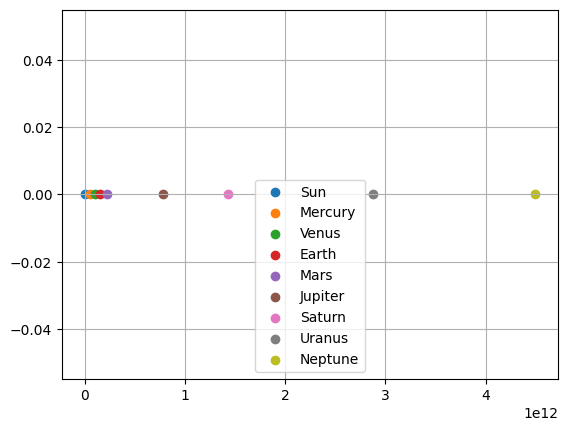

Shape of sol_odeint: (1825, 9, 2)


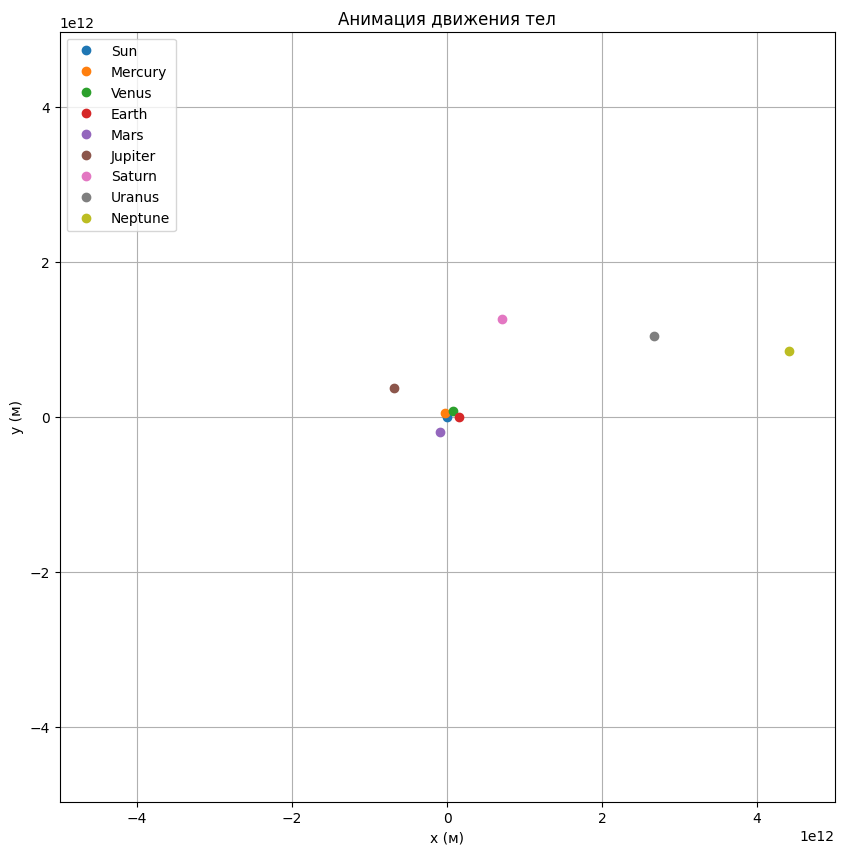

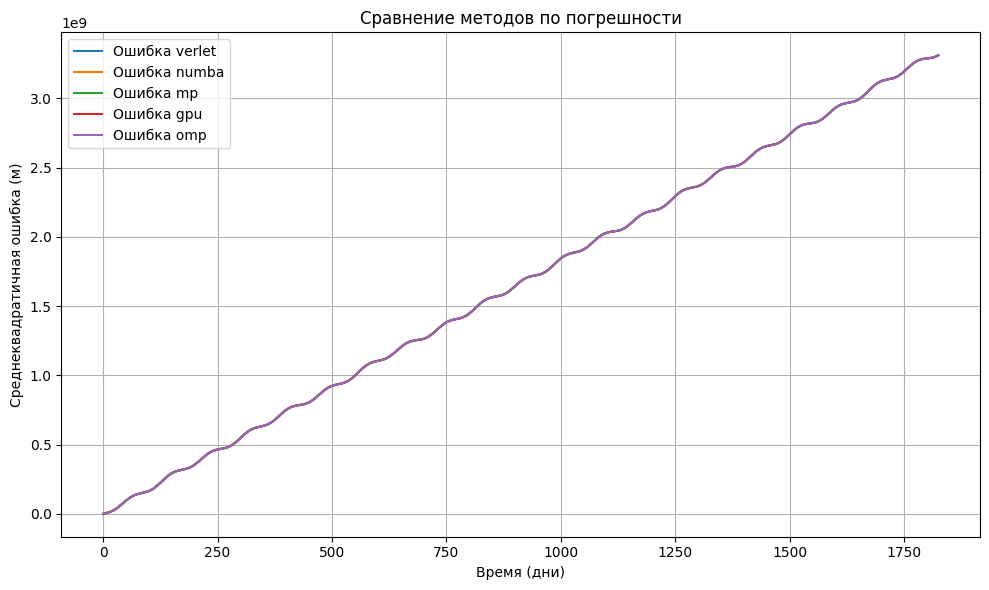

In [ ]:
compare_methods()

# Часть 3: Время работы

In [ ]:
import time
from verlet_omp import verlet_omp

def generate_particles(N):
    positions = np.random.uniform(-1e11, 1e11, (N, 2))
    velocities = np.random.uniform(-3e4, 3e4, (N, 2))
    masses = np.random.uniform(1e24, 1e30, N)
    return positions, velocities, masses

def benchmark_methods(N_values, dt=86400, steps=100):
    results = {'serial': [], 'numba': [], 'mp': [], 'gpu': [], 'omp': []}
    speedups = {'numba': [], 'mp': [], 'gpu': [], 'omp': []}

    for N in N_values:
        print(f"Замер для N={N}")
        pos, vel, masses = generate_particles(N)

        start = time.time()
        verlet_serial(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_serial1 = time.time() - start
        # results['serial1'].append(t_serial)

        start = time.time()
        verlet_serial(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_serial2 = time.time() - start
        # results['serial2'].append(t_serial)

        start = time.time()
        verlet_serial(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_serial3 = time.time() - start
        # results['serial3'].append(t_serial)

        t_serial = (t_serial1+t_serial2+t_serial3)/3
        results['serial'].append(t_serial)



        start = time.time()
        verlet_numba(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_numba1 = time.time() - start
        # results['numba'].append(t_numba)
        # speedups['numba'].append(t_serial / t_numba)

        start = time.time()
        verlet_numba(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_numba2 = time.time() - start

        start = time.time()
        verlet_numba(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_numba3 = time.time() - start

        t_numba = (t_numba1+t_numba2+t_numba3)/3
        results['numba'].append(t_numba)
        speedups['numba'].append(t_serial / t_numba)



        start = time.time()
        verlet_mp(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_mp1 = time.time() - start

        start = time.time()
        verlet_mp(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_mp2 = time.time() - start

        start = time.time()
        verlet_mp(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_mp3 = time.time() - start

        t_mp = (t_mp1+t_mp2+t_mp3)/3
        results['mp'].append(t_mp)
        speedups['mp'].append(t_serial / t_mp)



        start = time.time()
        verlet_integration(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_gpu1 = time.time() - start

        start = time.time()
        verlet_integration(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_gpu2 = time.time() - start

        start = time.time()
        verlet_integration(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_gpu3 = time.time() - start

        t_gpu = (t_gpu1+t_gpu2+t_gpu3)/3
        results['gpu'].append(t_gpu)
        speedups['gpu'].append(t_serial / t_gpu)


        start = time.time()
        verlet_omp(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_omp1 = time.time() - start

        start = time.time()
        verlet_omp(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_omp2 = time.time() - start

        start = time.time()
        verlet_omp(pos.copy(), vel.copy(), masses.copy(), dt, steps)
        t_omp3 = time.time() - start

        t_omp = (t_omp1+t_omp2+t_omp3)/3
        results['omp'].append(t_omp)
        speedups['omp'].append(t_serial / t_omp)

    return results, speedups

N_values = [100, 200, 400]
results, speedups = benchmark_methods(N_values)

for method in ['serial', 'numba', 'mp', 'gpu', 'omp']:
    if method in results:
      print(f'Время {method} = {results[method]}')

for method in ['numba', 'mp', 'gpu', 'omp']:
    if method in results:
      print(f'Ускорение {method} в {speedups[method]} раз')

plt.figure(figsize=(12, 6))
for method in ['serial', 'numba', 'mp', 'gpu', 'omp']:
    if method in results:
        plt.plot(N_values, results[method], 'o-', label=method)

plt.xlabel('Число частиц, N')
plt.ylabel('Время, с)')
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for method in ['numba', 'mp', 'gpu', 'omp']:
    if method in speedups:
        plt.plot(N_values, speedups[method], 'o-', label=method)
plt.xlabel('Число частиц, N')
plt.ylabel('Ускорение')
plt.legend()
plt.grid(True)
plt.show()

Замер для N=100
Замер для N=200
Замер для N=400
